# Neural Network Example

Build a 2-hidden layers fully connected neural network (a.k.a multilayer perceptron) with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building neural networks and the training process.

- Author: Miguel Tomás
- Project: https://github.com/aeonSolutions/TensorFlow-Examples

## Neural Network Overview

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

This example is using a file csv dataset.  

In this example, each dataset will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of "num_features" features 

More info: https://github.com/aeonSolutions/TensorFlow-Examples

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualize predictions.
import matplotlib.pyplot as plt

In [ ]:
# parameters initialization.
num_classes = 0 # total classes : number of output varibales
num_features = 1 # data features : number of input variables > load from the dataset bellow

# Training parameters.
learning_rate = 0.001
training_steps = 1000
batch_size = 256
display_step = 100

# Network parameters.
n_hidden_1 = 64 # 1st layer number of neurons.
n_hidden_2 = 64 # 2nd layer number of neurons.

In [ ]:
# make predictions Data.
df_predict_ds=pd.read_csv('./week3_exam_dataset_test.csv')

data_predict_x = np.float32(df_predict_ds.values)

# Training Data.
df_tr=pd.read_csv('./week3_exam_dataset_train.csv')

df_tr_raw_y= df_tr['y']
num_classes= df_tr_raw_y.shape[0]
if num_features==0:
    num_features= df_tr_raw_y.shape[0]

df_tr_raw_values_y = df_tr_raw_y.values
data_tr_y = np.float32(df_tr_raw_values_y)

df_tr_raw_x= df_tr.drop('y',1)
df_tr_raw_values_x = df_tr_raw_x.values
data_tr_x = np.float32(df_tr_raw_values_x)

x_train, x_test, y_train, y_test = train_test_split(df_tr_raw_x, df_tr_raw_y, test_size=0.33, random_state=42)

# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Convert to float32.
y_train, y_test = np.array(y_train, np.float32), np.array(y_test, np.float32)

# Normalize data values to [0, 1] interval.
maxVal=max(np.amax(x_train),np.amax(x_test))
x_train, x_test = x_train / maxVal, x_test / maxVal

In [ ]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Create TF Model.
class NeuralNet(Model):
    # Set layers.
    def __init__(self):
        super(NeuralNet, self).__init__()
        # First fully-connected hidden layer.
        self.fc1 = layers.Dense(n_hidden_1, activation=tf.nn.relu)
        # First fully-connected hidden layer.
        self.fc2 = layers.Dense(n_hidden_2, activation=tf.nn.relu)
        # Second fully-connecter hidden layer.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
neural_net = NeuralNet()

In [6]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Accuracy metric.
def accuracyAvg(y_pred):
    print(y_pred.numpy().shape)
    
    #convert to 1D array
    y_pred_1d_array= y_pred.ravel()
    
    accCalc= np.full(y_pred_1d_array.shape, 0)
    delta=np.amax(real_y_1d_array)-np.amin(real_y_1d_array)
    
    for i in range(len(y_pred_1d_array)):
        accCalc[i]= abs(delta-y_pred_1d_array[i] - real_y_1d_array[i])
    
    return accCalc

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [7]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = neural_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = neural_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [28]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
from datetime import timedelta

def live_plot(steps, accuracy, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.xlim(0, training_steps)
    plt.ylim(0, 100)
    steps= [float(i) for i in steps]
    accuracy= [float(i) for i in accuracy]
    
    if len(steps) > 1:
        plt.scatter(steps,accuracy, label='accuracy', color='k') 
        m, b = np.polyfit(steps, accuracy, 1)
        plt.plot(steps, [x * m for x in steps] + b)

    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('accuracy %')
    #plt.legend(loc='center left') # the plot evolves to the right
    plt.show();
    
def ETC(start, steps):
    time_elapsed = datetime.now() - start
    eta= (training_steps-steps) / display_step * time_elapsed
    #avgString = str(avg).split(".")[0]
    
    hours= int(eta.seconds/3600)
    minutes= int((eta.seconds/60)-hours*60)
    seconds = int(eta.seconds - minutes*60 -hours*3600)
    return "%sh, %s min and %s sec" % (hours, minutes, seconds)

def elapsedTime(elapsed):
    hours= int(elapsed.seconds/3600)
    minutes= int((elapsed.seconds/60)-hours*60)
    seconds = int(elapsed.seconds - minutes*60 -hours*3600)
    return "%sh, %s min and %s sec" % (hours, minutes, seconds)

def progress(percent=0, width=30):
    left = width * percent // 100
    right = width - left
    print('\r[', '#' * left, ' ' * right, ']',
          f' {percent:.0f}%\n',
          sep='', end='', flush=True)


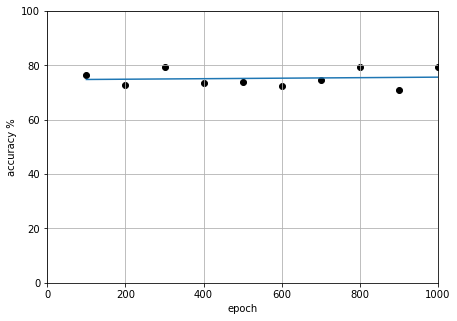

[##############################] 100%

================= Iteration Stats ================
                   step: 1000 of 1000
                   loss: 0.592776
               accuracy: 79.30 %
                    AVG: 75.23 %

================= Time           ================
                Elapsed: 0h, 3 min and 54 sec
                    ETC: 0h, 0 min and 0 sec

================== Network Setup ================
      number of classes: 32460
     number of features: 1
          learning rate: 0.001
         training steps: 1000
             batch size: 256
1st layer n. of neurons: 64
2st layer n. of neurons: 64

Analysis finished.
Final Average accuracy is 75.23 %


In [30]:
# Run training for the given number of steps.
avgCounter=0
avg=0.0

steps=[]
accuracyValue=[]

start_time = datetime.now()
totalStartTime=start_time
    
live_plot([0], [0])
print("analysis started. Waiting for preliminary data. One moment please...")
progress(0) 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
        
    if step % display_step == 0:
        pred = neural_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        avgCounter+=1
        avg+=acc*100
        
        steps.append(step)
        accuracyValue.append(acc*100)
        live_plot(steps, accuracyValue)
        totalTime =datetime.now()- totalStartTime
        
        if int(step/training_steps*100)<100:
            print("Running...")
        progress(int(step/training_steps*100)) 
        print("")
        print("================= Iteration Stats ================")
        print("                   step: %i of %i" % (step,training_steps))
        print("                   loss: %f" % loss)
        print("               accuracy: %.2f %%" %  (acc*100))
        print("                    AVG: %.2f %%" % (avg/avgCounter))
        print("")
        print("================= Time           ================")
        print("                Elapsed: " + elapsedTime(totalTime))
        print("                    ETC: " + ETC(start_time,step))
        print("")
        print("================= Network Setup  ================")
        print("      number of classes: "+ str(num_classes))
        print("     number of features: "+ str(num_features)) 

        print("          learning rate: "+ str(learning_rate))
        print("         training steps: "+ str(training_steps))
        print("             batch size: "+ str(batch_size))

        print("1st layer n. of neurons: "+ str(n_hidden_1 ))
        print("2st layer n. of neurons: "+ str(n_hidden_2))

        start_time = datetime.now()
print("")
print("Analysis finished.")        
#print("Final Average accuracy is %.2f %%" % (avg/avgCounter))

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++
#!!! code bellow this line is not yet finished !!!
# +++++++++++++++++++++++++++++++++++++++++++++++++++

# Test model on validation set.
print(x_test.shape)

pred = neural_net(x_test, is_training=False)

print("Accuracy of highest score in prediction vector")
print("         Test Accuracy: %.2f %%" % (tf.math.round(100*accuracy(pred, y_test))))
print("")

prediction= np.round(pred.numpy(),2)
print("Model prediction shape:"  + str(prediction.shape))
print("   Model initial shape:"  + str(y_test.shape))

print("")
print("Model prediction value:")
print(prediction)

In [ ]:
predictions = neural_net(data_predict_x)
print("Model prediction: %i" % np.argmax(predictions.numpy()))


 Author: Miguel Tomás 

 License: Creative Commons 
